In [1]:
import scipy.io #initializes libraries
import os
import time
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from natsort import natsorted

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler


from torch.nn.utils.rnn import pad_sequence


# Data Processing

### Standard Batch Based

In [2]:
# Load Data
parquet_path = r'C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\cells_cleaned.parquet'
df = pd.read_parquet(parquet_path)
df.head()

,Step_Time(s),Step_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Cycle,Window,EUC,Cell
0,8208.450688,8.0,4.000000,0.040119,2.899512,0.000002,25.115520,17.759035,0.000011,1,Window_34,18.609287,G1
1,8213.450728,8.0,4.000015,0.040134,2.899568,0.000002,25.115741,17.759035,-0.000013,1,Window_34,18.609287,G1
2,8218.450720,8.0,3.999986,0.039902,2.899624,0.000002,25.115965,17.759035,-0.000008,1,Window_34,18.609287,G1
3,8223.450732,8.0,4.000014,0.040099,2.899679,0.000002,25.116186,17.759035,0.000013,1,Window_34,18.609287,G1
4,8228.450682,8.0,3.999994,0.039210,2.899734,0.000002,25.116406,17.759035,-0.000021,1,Window_34,18.609287,G1


In [3]:
class ANN_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

In [4]:
def arrange_columns(df, input_dimension = 12):
    num_columns = len(df.columns)
    if num_columns < input_dimension:
        # Add additional columns with zero values
        for i in range(input_dimension - num_columns):
            df[f'Extra_Column_{i+1}'] = 0
    elif num_columns > input_dimension:
        # Remove extra columns
        df = df.iloc[:, :input_dimension]  # Keep only the first 12 columns
    return df

In [5]:
# train_cells_list = ['G1', 'V4', 'W5', 'W8', 'W9', 'W10']
# test_cells_list = ['V5', 'W3', 'W4', 'W7']
train_cells_list = ["G1", "V4", "W5","W8"]
# train_cells_list = ['G1', 'V4']
test_cells_list = ["W9", "W10"]
C_rates = {'G1': 3, 'V4': 0.25, 'W5': 0.5, 'W8': 0.5, 'W9': 1, 'W10': 3, 'V5': 1, 'W3': 3, 'W4': 0.25, 'W7': 0.25}
scaler = MinMaxScaler()

In [6]:
df_all = df.copy()
df_all['C_rate'] = df_all['Cell'].map(C_rates)
df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)

train_data = pd.get_dummies(df_all[df_all['Cell'].isin(train_cells_list)].drop(columns=['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors = 'coerce')[:]
test_data = pd.get_dummies(df_all[df_all['Cell'].isin(test_cells_list)].drop(columns = ['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors='coerce')[:]

train_data = train_data.drop(columns = ['Cycle', 'Window', 'EUC', 'Step_Time(s)'])
test_data = test_data.drop(columns = ['Cycle', 'Window', 'EUC', 'Step_Time(s)'])

train_data = arrange_columns(train_data)
test_data = arrange_columns(test_data)

train_columns = train_data.columns
test_columns = test_data.columns

train_features = scaler.fit_transform(train_data.drop(columns=['Discharge_Capacity(Ah)']))
train_labels = scaler.fit_transform(train_data['Discharge_Capacity(Ah)'].values.reshape(-1, 1))

test_features = scaler.fit_transform(test_data.drop(columns=['Discharge_Capacity(Ah)']))
test_labels = scaler.fit_transform(test_data['Discharge_Capacity(Ah)'].values.reshape(-1, 1))


print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)


del df_all, df

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC_4766\AppData\Local\Temp\ipykernel_16056\3789433212.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)


(7804810, 11) (4544240, 11)
(7804810, 1) (4544240, 1)


In [23]:
print(test_features.shape)

(4544240, 9)


In [7]:
train_dataset = ANN_Dataset(train_features, train_labels)
val_dataset = ANN_Dataset(test_features, test_labels)

test_dataset = ANN_Dataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)

### Cycle based

In [2]:
# Load Data
parquet_path = r'C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\cells_cleaned.parquet'
df = pd.read_parquet(parquet_path)
df.head()

,Step_Time(s),Step_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Cycle,Window,EUC,Cell
0,8208.450688,8.0,4.000000,0.040119,2.899512,0.000002,25.115520,17.759035,0.000011,1,Window_34,18.609287,G1
1,8213.450728,8.0,4.000015,0.040134,2.899568,0.000002,25.115741,17.759035,-0.000013,1,Window_34,18.609287,G1
2,8218.450720,8.0,3.999986,0.039902,2.899624,0.000002,25.115965,17.759035,-0.000008,1,Window_34,18.609287,G1
3,8223.450732,8.0,4.000014,0.040099,2.899679,0.000002,25.116186,17.759035,0.000013,1,Window_34,18.609287,G1
4,8228.450682,8.0,3.999994,0.039210,2.899734,0.000002,25.116406,17.759035,-0.000021,1,Window_34,18.609287,G1


In [3]:
class ANN_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        print(len(self.data['Window'].unique()))
        return len(self.data['Window'].unique())
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

In [61]:
train = train_features.groupby('Window')
train

In [4]:
train_cells_list = ['G1', 'V4', 'W5', 'W8', 'W9', 'W10']
test_cells_list = ['V5', 'W3', 'W4', 'W7']
C_rates = {'G1': 3, 'V4': 0.25, 'W5': 23, 'W8': 23, 'W9': 1, 'W10': 3, 'V5': 1, 'W3': 3, 'W4': 0.25, 'W7': 0.25}
scaler = MinMaxScaler()

In [5]:
df_all = df.copy()
df_all['C_rate'] = df_all['Cell'].map(C_rates)
df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)

train_data = pd.get_dummies(df_all[df_all['Cell'].isin(["G1", "V4", "W5","W8"])].drop(columns=['Step_Index', 'Cycle']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors = 'coerce')[:]
test_data = pd.get_dummies(df_all[df_all['Cell'].isin(["W9", "W10"])].drop(columns = ['Step_Index', 'Cycle']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors='coerce')[:]

# train_features = scaler.fit_transform(train_data.drop(columns=['Discharge_Capacity(Ah)']))
# train_labels = scaler.fit_transform(train_data['Discharge_Capacity(Ah)'].values.reshape(-1, 1))
ss = StandardScaler()
# train_features = DataFrameMapper([(train_data.drop(columns=['Discharge_Capacity(Ah)']).columns, StandardScaler())]).fit_transform()
train_features = pd.DataFrame(ss.fit_transform(train_data.drop(columns=['Discharge_Capacity(Ah)'])), columns = train_data.drop(columns=['Discharge_Capacity(Ah)']).columns)
train_labels = pd.DataFrame(ss.fit_transform(train_data[['Discharge_Capacity(Ah)']]), columns = ['Discharge_Capacity(Ah)'])

del df_all, df

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC_4766\AppData\Local\Temp\ipykernel_7512\3030347066.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)


In [55]:
train_dataset = ANN_Dataset(train_features, train_labels)
val_dataset = ANN_Dataset(train_features, train_labels)

train_loader = DataLoader(train_dataset, batch_size = 4048, shuffle = False)
val_loader = DataLoader(train_dataset, batch_size = 4048, shuffle = True)

972
972


# Model

In [8]:
class LSTM_v1(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers):
    super().__init__()

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 1)

  def forward(self, input):
    output, (h_n, c_n) = self.lstm(input)
    # print(output.shape, h_n.shape, c_n.shape)
    out = self.fc(output)
    
    return out.view(input.size(0))

In [9]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob = 0.5):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    # def forward(self, x):
    #     x = self.dropout(torch.relu(self.fc1(x)))
    #     x = self.dropout(torch.relu(self.fc2(x)))
    #     x = self.dropout(torch.relu(self.fc2(x)))
    #     x = self.dropout(torch.relu(self.fc2(x)))
    #     x = self.dropout(torch.relu(self.fc2(x)))
    #     x = self.fc3(x)
    #     return x

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))

        x = self.fc3(x)
        return x

class ANN_v3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob = 0.5):
        super(ANN_v3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

        self._initialize_weights()
    
    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout(torch.relu(self.bn1(self.fc2(x))))
        x = self.dropout(torch.relu(self.bn1(self.fc2(x))))
        x = self.dropout(torch.relu(self.bn1(self.fc2(x))))
        x = self.dropout(torch.relu(self.bn1(self.fc2(x))))
        x = self.fc3(x)
        return x

class ANN_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Dropout(0.25, inplace=True),
            nn.Linear(12, 50),
            nn.ReLU(),
            nn.Linear(50, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        # x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

class ANN_Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(11, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        out = self.linear(x)
        return out



# Train

### Train with Epoch

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 12
hidden_size = 32
output_size = 1
learning_rate = 0.000001
num_epochs = 100
hidden_dim = 6
num_layers = 2

# Initialize the model, loss function, and optimizer

# model = ANN_v2().to(device)
# model = ANN(input_size, hidden_size, output_size).to(device)
model = ANN_Simple().to(device)
# model = ANN_v3(input_size, hidden_size, output_size).to(device)
# model = LSTM_v1(input_size, hidden_dim, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)
      optimizer.zero_grad()
      # Forward pass
      outputs = model(features.float())
      loss = criterion(outputs.float(), labels.float())
      # Backward pass and optimization
      loss.backward()
      optimizer.step()
      total_loss = total_loss + loss.item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.8f}')

# Save the model
checkpoint_path = r"C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\Codes\Final_codes\Checkpoints\ANN_Simple_128_v4.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, checkpoint_path)

Epoch [1/100], Train Loss: 0.09319868
Epoch [2/100], Train Loss: 0.03218512
Epoch [3/100], Train Loss: 0.01757237
Epoch [4/100], Train Loss: 0.01504939
Epoch [5/100], Train Loss: 0.01419154
Epoch [6/100], Train Loss: 0.01354779
Epoch [7/100], Train Loss: 0.01301670
Epoch [8/100], Train Loss: 0.01251779
Epoch [9/100], Train Loss: 0.01200971
Epoch [10/100], Train Loss: 0.01153484
Epoch [11/100], Train Loss: 0.01105919
Epoch [12/100], Train Loss: 0.01057975
Epoch [13/100], Train Loss: 0.01009341
Epoch [14/100], Train Loss: 0.00957870
Epoch [15/100], Train Loss: 0.00903517
Epoch [16/100], Train Loss: 0.00847553
Epoch [17/100], Train Loss: 0.00790575
Epoch [18/100], Train Loss: 0.00734390
Epoch [19/100], Train Loss: 0.00678551
Epoch [20/100], Train Loss: 0.00623771
Epoch [21/100], Train Loss: 0.00569091
Epoch [22/100], Train Loss: 0.00514635
Epoch [23/100], Train Loss: 0.00461108
Epoch [24/100], Train Loss: 0.00411687
Epoch [25/100], Train Loss: 0.00367062
Epoch [26/100], Train Loss: 0.0032

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 11
hidden_size = 32
output_size = 1
learning_rate = 0.000001
num_epochs = 100
hidden_dim = 6
num_layers = 2

# Initialize the model, loss function, and optimizer

# model = ANN_v2().to(device)
model = ANN(input_size, hidden_size, output_size).to(device)
# model = ANN_Simple().to(device)
# model = ANN_v3(input_size, hidden_size, output_size).to(device)
# model = LSTM_v1(input_size, hidden_dim, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)
      optimizer.zero_grad()
      # Forward pass
      outputs = model(features.float())
      loss = criterion(outputs.float(), labels.float())
      # Backward pass and optimization
      loss.backward()
      optimizer.step()
      total_loss = total_loss + loss.item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.8f}')
# Save the model
checkpoint_path = r"C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\Codes\Final_codes\Checkpoints\ANN_128_v4.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, checkpoint_path)

Epoch [1/100], Train Loss: 0.10344512
Epoch [2/100], Train Loss: 0.02667602
Epoch [3/100], Train Loss: 0.01350552
Epoch [4/100], Train Loss: 0.01308275
Epoch [5/100], Train Loss: 0.01273598
Epoch [6/100], Train Loss: 0.01243422
Epoch [7/100], Train Loss: 0.01210936
Epoch [8/100], Train Loss: 0.01175257
Epoch [9/100], Train Loss: 0.01137322
Epoch [10/100], Train Loss: 0.01093806
Epoch [11/100], Train Loss: 0.01043702
Epoch [12/100], Train Loss: 0.00980661
Epoch [13/100], Train Loss: 0.00897962
Epoch [14/100], Train Loss: 0.00791145
Epoch [15/100], Train Loss: 0.00648532
Epoch [16/100], Train Loss: 0.00484597
Epoch [17/100], Train Loss: 0.00341768
Epoch [18/100], Train Loss: 0.00253636
Epoch [19/100], Train Loss: 0.00205547
Epoch [20/100], Train Loss: 0.00173437
Epoch [21/100], Train Loss: 0.00143134
Epoch [22/100], Train Loss: 0.00124968
Epoch [23/100], Train Loss: 0.00111516
Epoch [24/100], Train Loss: 0.00101195
Epoch [25/100], Train Loss: 0.00093216
Epoch [26/100], Train Loss: 0.0008

### Train with Early Stopping

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 15
hidden_size = 32
output_size = 1
learning_rate = 1e-5
num_epochs = 100

# Initialize the model, loss function, and optimizer
# model = ANN_v2().to(device)
# model = ANN(input_size, hidden_size, output_size).to(device)
model = ANN_Simple().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Define early stopping parameters
patience = 5  # Number of epochs to wait before early stopping if no improvement
min_delta = 0.000001  # Minimum change in validation loss to qualify as an improvement
best_loss = float('inf')
early_stopping_counter = 0
best_model_weights = None


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)
      optimizer.zero_grad()
      # Forward pass
      outputs = model(features.float())
      loss = criterion(outputs.float(), labels.float()).reshape(-1, 1)
      # Backward pass and optimization
      loss.backward()
      optimizer.step()
      total_loss = total_loss + loss.item()

    model.eval()
    with torch.no_grad():
      val_loss = 0
      for val_features, val_labels in val_loader:
        val_features, val_labels = val_features.to(device), val_labels.to(device)
        val_outputs = model(val_features.float())
        val_loss += criterion(val_outputs.float(), val_labels.float()).item()
      val_loss /= len(val_loader)

     # Check for improvement in validation loss
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stopping_counter = 0
        # Save the best model weights
        best_model_weights = model.state_dict()
    else:
        early_stopping_counter += 1


    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.8f}, Val Loss: {val_loss:.8f}')

    # Check if early stopping criteria are met
    if early_stopping_counter >= patience:
        print("Early stopping triggered!")
        break

# Load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

# Save the model
checkpoint_path = r"C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\Codes\Final_codes\Checkpoints\ANN_Simple_128_v3.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, checkpoint_path)

Epoch [1/100], Train Loss: 0.02954114, Val Loss: 0.00832845
Epoch [2/100], Train Loss: 0.00453031, Val Loss: 0.01471915
Epoch [3/100], Train Loss: 0.00192415, Val Loss: 0.01511842
Epoch [4/100], Train Loss: 0.00155528, Val Loss: 0.01407443
Epoch [5/100], Train Loss: 0.00134530, Val Loss: 0.01350399
Epoch [6/100], Train Loss: 0.00118311, Val Loss: 0.01309105
Early stopping triggered!


In [45]:
checkpoint_path = r"C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\Codes\Final_codes\Checkpoints\ANN_v2_64.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, checkpoint_path)

# Evaluation

### Load Data with Pandas form

In [4]:
# Load Data
parquet_path = r'C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\cells_cleaned.parquet'
df = pd.read_parquet(parquet_path)
df.head()

,Step_Time(s),Step_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Cycle,Window,EUC,Cell
0,8208.450688,8.0,4.000000,0.040119,2.899512,0.000002,25.115520,17.759035,0.000011,1,Window_34,18.609287,G1
1,8213.450728,8.0,4.000015,0.040134,2.899568,0.000002,25.115741,17.759035,-0.000013,1,Window_34,18.609287,G1
2,8218.450720,8.0,3.999986,0.039902,2.899624,0.000002,25.115965,17.759035,-0.000008,1,Window_34,18.609287,G1
3,8223.450732,8.0,4.000014,0.040099,2.899679,0.000002,25.116186,17.759035,0.000013,1,Window_34,18.609287,G1
4,8228.450682,8.0,3.999994,0.039210,2.899734,0.000002,25.116406,17.759035,-0.000021,1,Window_34,18.609287,G1


In [6]:
# train_cells_list = ['G1', 'V4', 'W5', 'W8', 'W9', 'W10']
# test_cells_list = ['V5', 'W3', 'W4', 'W7']
train_cells_list = ["G1", "V4", "W5","W8"]
# train_cells_list = ['G1', 'V4']
test_cells_list = ["W9", "W10"]
C_rates = {'G1': 3, 'V4': 0.25, 'W5': 0.5, 'W8': 0.5, 'W9': 1, 'W10': 3, 'V5': 1, 'W3': 3, 'W4': 0.25, 'W7': 0.25}
scaler = MinMaxScaler()

In [7]:
df_all = df.copy()
df_all['C_rate'] = df_all['Cell'].map(C_rates)
df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)

train_data = pd.get_dummies(df_all[df_all['Cell'].isin(train_cells_list)].drop(columns=['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors = 'coerce')[:]
test_data = pd.get_dummies(df_all[df_all['Cell'].isin(test_cells_list)].drop(columns = ['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors='coerce')[:]

train_data = train_data.drop(columns = ['Cycle', 'Window', 'EUC'])
test_data = test_data.drop(columns = ['Cycle', 'Window', 'EUC'])

train_feature_columns = train_data.columns.tolist()
train_feature_columns.remove('Discharge_Capacity(Ah)')
print(train_feature_columns)

test_feature_columns = test_data.columns.tolist()
test_feature_columns.remove('Discharge_Capacity(Ah)')

label_column = ['Discharge_Capacity(Ah)']

train_features = scaler.fit_transform(train_data.drop(columns=['Discharge_Capacity(Ah)']))
train_features = pd.DataFrame(train_features, columns = train_feature_columns)

train_labels = scaler.fit_transform(train_data['Discharge_Capacity(Ah)'].values.reshape(-1, 1))
train_labels = pd.DataFrame(train_labels, columns = label_column)

test_features = scaler.fit_transform(test_data.drop(columns=['Discharge_Capacity(Ah)']))
test_features = pd.DataFrame(test_features, columns = test_feature_columns)

test_labels = scaler.fit_transform(test_data['Discharge_Capacity(Ah)'].values.reshape(-1, 1))
test_labels = pd.DataFrame(test_labels, columns = label_column)
del df_all

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC_4766\AppData\Local\Temp\ipykernel_5884\486676563.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)


['Step_Time(s)', 'Voltage(V)', 'Current(A)', 'Charge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'C_rate', 'Cell_G1', 'Cell_V4', 'Cell_W5', 'Cell_W8']


In [8]:
all_features = pd.concat([train_features, test_features], ignore_index = True)
all_features = all_features.fillna(0)

all_labels = pd.concat([train_labels, test_labels], ignore_index = True)
all_labels = all_labels.fillna(0)

In [16]:
### Arrange columns of the dataset to get the correct dimension for model input (smth, 12)

def arrange_columns(df, input_dimension = 12):
    num_columns = len(df.columns)
    if num_columns < input_dimension:
        # Add additional columns with zero values
        for i in range(input_dimension - num_columns):
            df[f'Extra_Column_{i+1}'] = 0
    elif num_columns > input_dimension:
        # Remove extra columns
        df = df.iloc[:, :input_dimension]  # Keep only the first 12 columns
    return df

### Test the model

In [41]:
### Load the model and checkpoint parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 11
hidden_size = 32
output_size = 1
learning_rate = 0.000001
num_epochs = 100
hidden_dim = 6
num_layers = 2
checkpoint_path = r"C:\Users\PC_4766\Desktop\Sanan\Codes\Bitirme\Codes\Final_codes\Checkpoints\ANN_128_v4.pth"
# model = ANN_v2().to(device)
# model = ANN_Simple().to(device)
model = ANN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [20]:
### Load Data to PyTorch - this part will not be used
all_data = ANN_Dataset(all_features.to_numpy(), all_labels.to_numpy())
all_loader = DataLoader(all_data, batch_size = 128, shuffle = False)

In [42]:
with torch.no_grad():
  # train_features = arrange_columns(train_features, input_dimension = 11)
  # test_features = arrange_columns(test_features, input_dimension = 11)

  # train_predictions = model(torch.tensor(train_features.to_numpy()).float())
  # test_predictions = model(torch.tensor(test_features.to_numpy()).float())

  train_predictions = model(torch.tensor(train_features).float())
  test_predictions = model(torch.tensor(test_features).float())

In [43]:
train_predictions.shape, test_predictions.shape

(torch.Size([7804810, 1]), torch.Size([4544240, 1]))

In [45]:
train_labels_df = pd.DataFrame({
    'Predictions': train_predictions.numpy().flatten(),
    'Actual': train_labels.flatten()
})

test_labels_df = pd.DataFrame({
    'Predictions': test_predictions.numpy().flatten(),
    'Actual': test_labels.flatten()
})

In [46]:
### Metrics for Train data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
mse = mean_squared_error(train_labels_df['Actual'], train_labels_df['Predictions'])
mae = mean_absolute_error(train_labels_df['Actual'], train_labels_df['Predictions'])
r_squared = r2_score(train_labels_df['Actual'], train_labels_df['Predictions'])
rmse = root_mean_squared_error(train_labels_df['Actual'], train_labels_df['Predictions'])


print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

MSE: 0.00029245510434646794
MAE: 0.0060069567507888095
R-squared: 0.9971542492534989
RMSE: 0.017101318789686015


In [47]:
### Metrics for test data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(test_labels_df['Actual'], test_labels_df['Predictions'])
mae = mean_absolute_error(test_labels_df['Actual'], test_labels_df['Predictions'])
r_squared = r2_score(test_labels_df['Actual'], test_labels_df['Predictions'])
rmse = root_mean_squared_error(test_labels_df['Actual'], test_labels_df['Predictions'])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

MSE: 0.005179227846736278
MAE: 0.0477876121817494
R-squared: 0.9499091294751913
RMSE: 0.07196685241648601


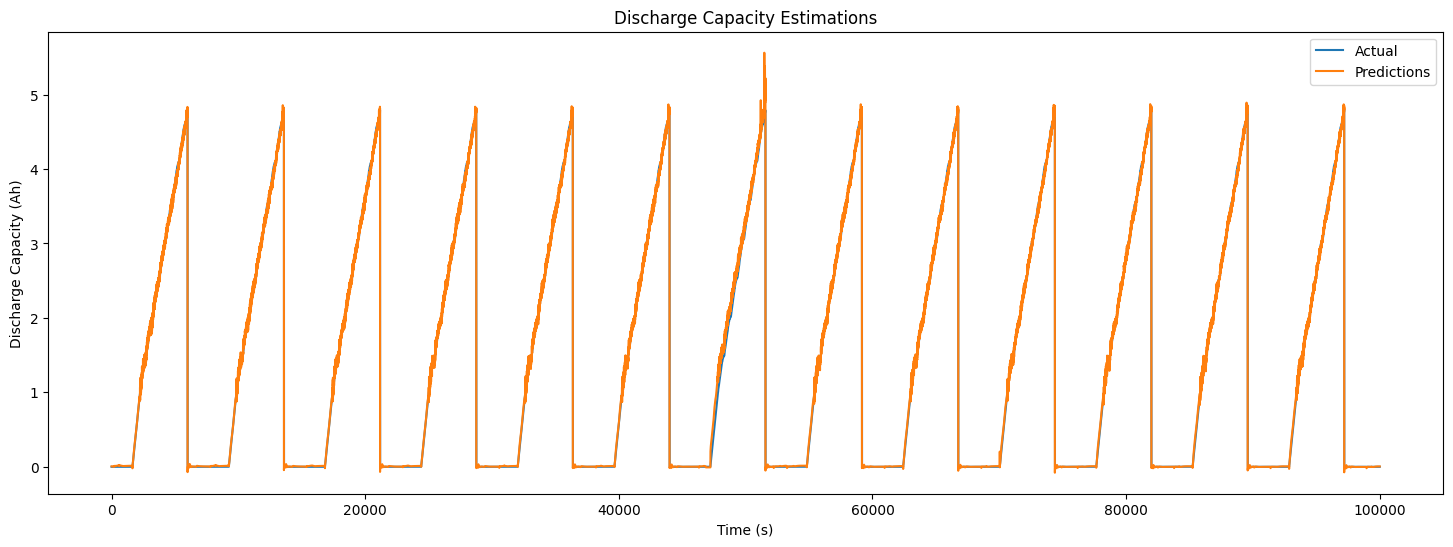

In [48]:
plt.figure(figsize=(18, 6))
plt.plot(scaler.inverse_transform(train_labels_df[['Actual']][:100000]), label='Actual')
plt.plot(scaler.inverse_transform(train_labels_df[['Predictions']][:100000]), label='Predictions')

plt.title('Discharge Capacity Estimations')
plt.xlabel('Time (s)')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.show()

In [195]:
### Add train predictions to main train dataset
# train_labels['Predictions_unscaled'] = scaler.inverse_transform(train_labels[['Predictions']])
df_all = df.copy()
df_all['C_rate'] = df_all['Cell'].map(C_rates)
df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)

train_data = pd.get_dummies(df_all[df_all['Cell'].isin(train_cells_list)].drop(columns=['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors = 'coerce')[:]
test_data = pd.get_dummies(df_all[df_all['Cell'].isin(test_cells_list)].drop(columns = ['Step_Index']), columns = ['Cell'], dtype = 'float').apply(pd.to_numeric, errors='coerce')[:]

train_data = train_data.drop(columns = ['Cycle', 'EUC'])
test_data = test_data.drop(columns = ['Cycle', 'EUC'])

print(train_labels['Predictions'])
train_data['Predictions'] = train_labels['Predictions_unscaled'].tolist()
# # test_data['Predictions'] = test_labels['Predictions_unscaled']

# window_names_train = natsorted(train_data.Window.unique())
# print(window_names_train)
# # window_names_test = natsorted(test_data.Window.unique())

# window_to_cycle_train = {window: idx + 1 for idx, window in enumerate(natsorted(window_names_train))}
# # window_to_cycle_test = {window: idx + 1 for idx, window in enumerate(window_names_test)}

# train_data['Cycle'] = train_data['Window'].map(window_to_cycle_train)
# # test_data['Cycle'] = test_data['Window'].map(window_names_test)
    

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC_4766\AppData\Local\Temp\ipykernel_12356\3661314477.py:5: SyntaxWarning: invalid escape sequence '\d'
  df_all['Window'] = df_all['Window'].str.extract('(\d+)').astype(int)


0          0.001371
1          0.001373
2          0.001376
3          0.001378
4          0.001378
             ...   
7804805    0.000374
7804806    0.000375
7804807    0.000361
7804808    0.000354
7804809    0.000332
Name: Predictions, Length: 7804810, dtype: float32


In [196]:
train_data

,Step_Time(s),Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Window,C_rate,Cell_G1,Cell_V4,Cell_W5,Cell_W8,Predictions
0,8208.450688,4.000000,0.040119,2.899512,0.000002,25.115520,17.759035,0.000011,34,3.0,1.0,0.0,0.0,0.0,0.006573
1,8213.450728,4.000015,0.040134,2.899568,0.000002,25.115741,17.759035,-0.000013,34,3.0,1.0,0.0,0.0,0.0,0.006581
2,8218.450720,3.999986,0.039902,2.899624,0.000002,25.115965,17.759035,-0.000008,34,3.0,1.0,0.0,0.0,0.0,0.006596
3,8223.450732,4.000014,0.040099,2.899679,0.000002,25.116186,17.759035,0.000013,34,3.0,1.0,0.0,0.0,0.0,0.006607
4,8228.450682,3.999994,0.039210,2.899734,0.000002,25.116406,17.759035,-0.000021,34,3.0,1.0,0.0,0.0,0.0,0.006606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045505,818.000880,4.137134,1.212635,2.839329,0.000068,424.232153,392.744263,0.000116,101401,0.5,0.0,0.0,0.0,1.0,0.001792
10045506,823.000860,4.137515,1.212656,2.841013,0.000068,424.239124,392.744263,0.000015,101401,0.5,0.0,0.0,0.0,1.0,0.001795
10045507,828.000600,4.137922,1.212642,2.842698,0.000068,424.246094,392.744263,0.000089,101401,0.5,0.0,0.0,0.0,1.0,0.001730
10045508,833.000760,4.138333,1.212634,2.844382,0.000068,424.253070,392.744263,0.000086,101401,0.5,0.0,0.0,0.0,1.0,0.001699


In [203]:
plt.figure(figsize=(18, 6))
plt.plot(scaler.inverse_transform(train_labels[['Discharge_Capacity(Ah)']][:1000]), label='Actual')
plt.plot(scaler.inverse_transform(train_labels[['Predictions']][:1000]), label='Predictions')

plt.title('Discharge Capacity Estimations')
plt.xlabel('Time (s)')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.show()

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 1800x600 with 0 Axes>

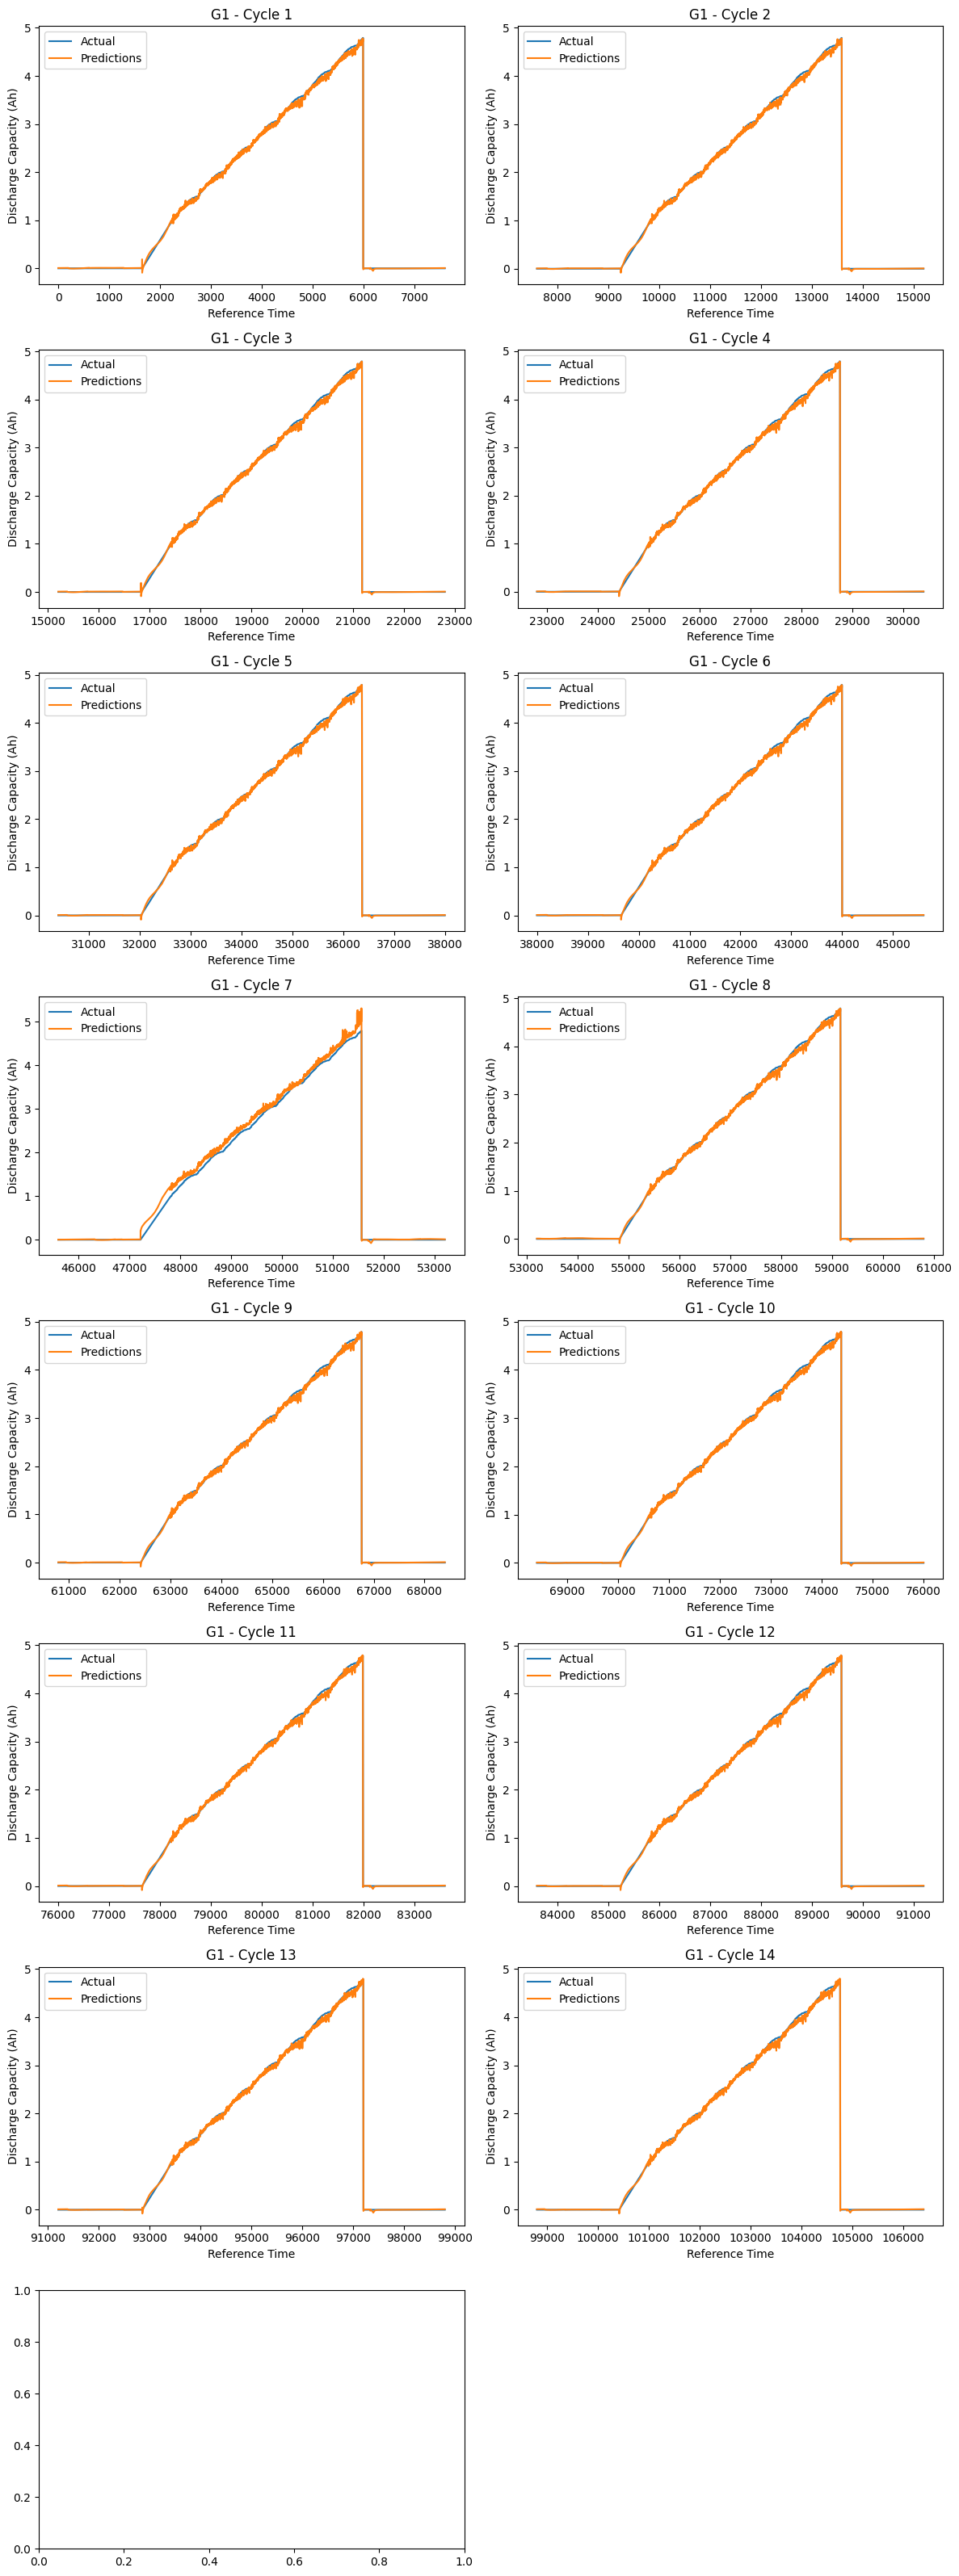

In [202]:
cycles = train_data["Window"][:100000].unique()
cycle_num = len(cycles)

cols = 2
rows = (cycle_num + 2) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()
num = 1
for j, cycle in enumerate(cycles):
    sub_df = train_data[train_data["Window"] == cycle]
    y1 = sub_df["Discharge_Capacity(Ah)"]
    x1 = sub_df.index

    y2 = sub_df["Predictions"]
    axes[j].plot(x1, y1, label=f"Actual")
    axes[j].plot(x1, y2, label=f"Predictions")
    axes[j].set_title(f"G1 - Cycle {num}")
    axes[j].set_xlabel("Time (s)")
    axes[j].set_ylabel("Discharge Capacity (Ah)")
    axes[j].legend(loc='upper left')
    num = num + 1

for j in range(cycle_num+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

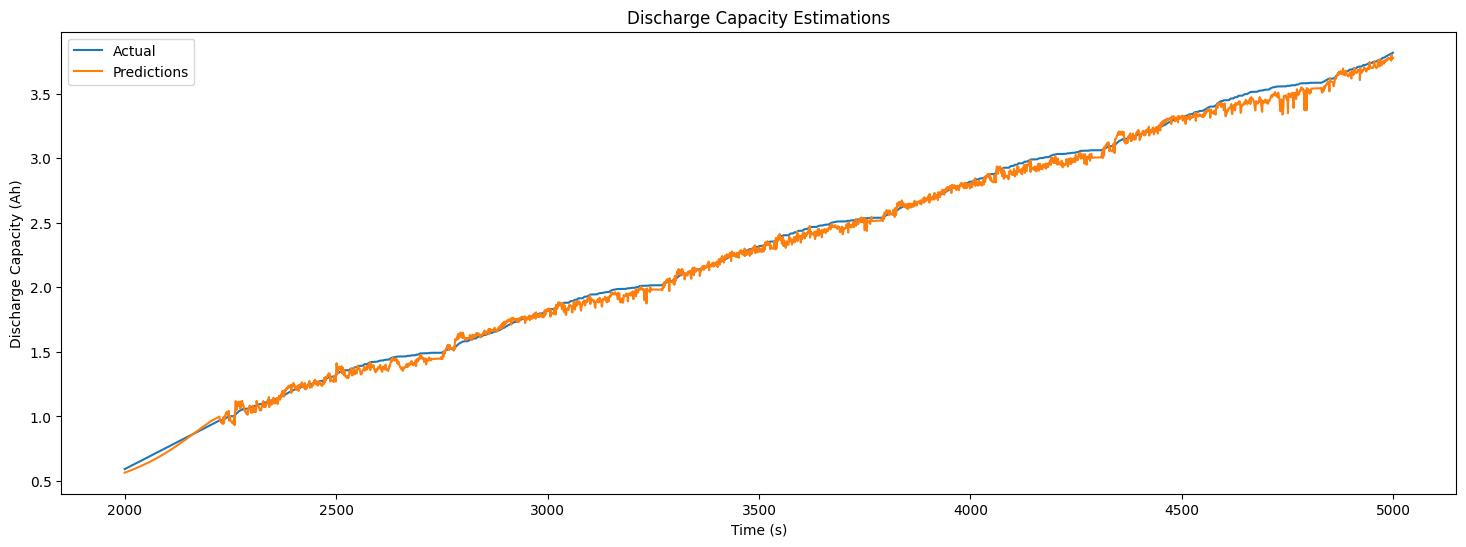

In [210]:
plt.figure(figsize=(18, 6))
plt.plot(train_data['Discharge_Capacity(Ah)'][2000:5000], label='Actual')
plt.plot(train_data['Predictions'][2000:5000], label='Predictions')

plt.title('Discharge Capacity Estimations')
plt.xlabel('Time (s)')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.show()

In [212]:
train_data

,Step_Time(s),Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Window,C_rate,Cell_G1,Cell_V4,Cell_W5,Cell_W8,Predictions
0,8208.450688,4.000000,0.040119,2.899512,0.000002,25.115520,17.759035,0.000011,34,3.0,1.0,0.0,0.0,0.0,0.006573
1,8213.450728,4.000015,0.040134,2.899568,0.000002,25.115741,17.759035,-0.000013,34,3.0,1.0,0.0,0.0,0.0,0.006581
2,8218.450720,3.999986,0.039902,2.899624,0.000002,25.115965,17.759035,-0.000008,34,3.0,1.0,0.0,0.0,0.0,0.006596
3,8223.450732,4.000014,0.040099,2.899679,0.000002,25.116186,17.759035,0.000013,34,3.0,1.0,0.0,0.0,0.0,0.006607
4,8228.450682,3.999994,0.039210,2.899734,0.000002,25.116406,17.759035,-0.000021,34,3.0,1.0,0.0,0.0,0.0,0.006606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045505,818.000880,4.137134,1.212635,2.839329,0.000068,424.232153,392.744263,0.000116,101401,0.5,0.0,0.0,0.0,1.0,0.001792
10045506,823.000860,4.137515,1.212656,2.841013,0.000068,424.239124,392.744263,0.000015,101401,0.5,0.0,0.0,0.0,1.0,0.001795
10045507,828.000600,4.137922,1.212642,2.842698,0.000068,424.246094,392.744263,0.000089,101401,0.5,0.0,0.0,0.0,1.0,0.001730
10045508,833.000760,4.138333,1.212634,2.844382,0.000068,424.253070,392.744263,0.000086,101401,0.5,0.0,0.0,0.0,1.0,0.001699


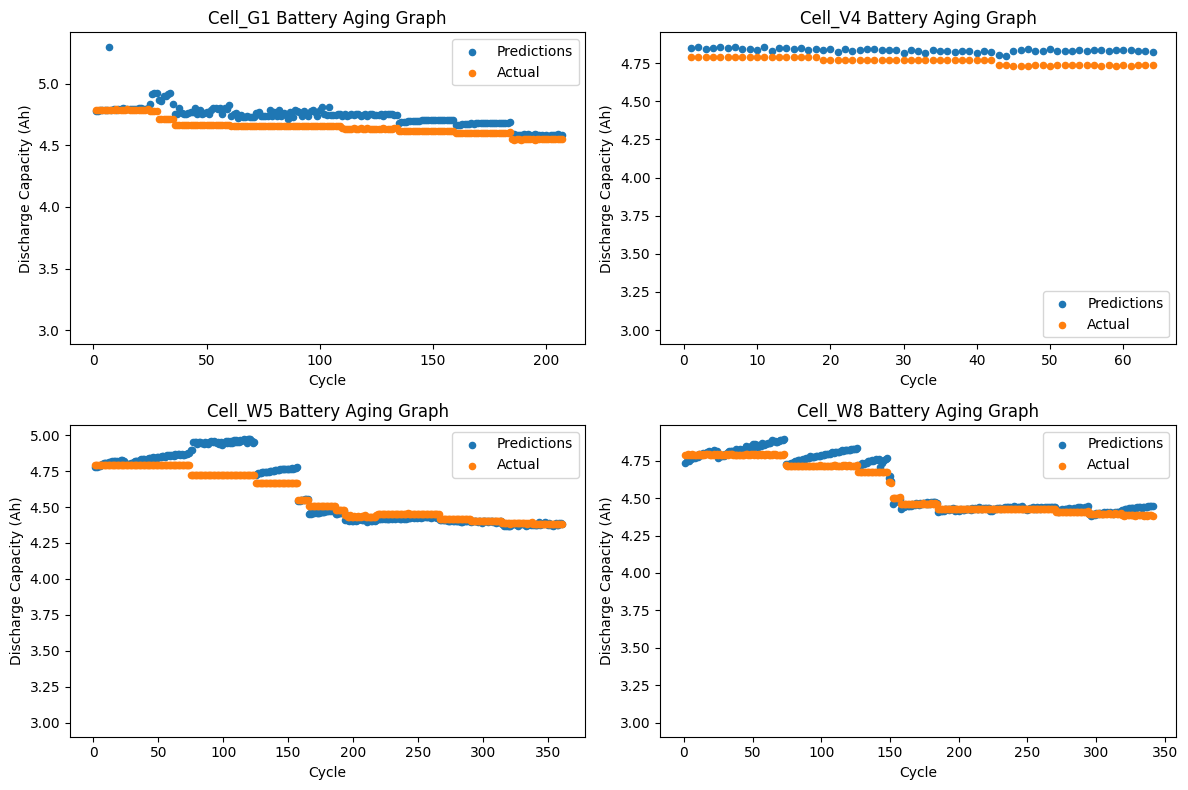

In [239]:
cell_names = ['Cell_G1', 'Cell_V4', 'Cell_W5', 'Cell_W8']
rows = 2
columns = 2
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()
for j, cell_name in enumerate(cell_names):
    train_soh_pred = train_data[train_data[cell_name]==1]
    train_soh_pred = train_soh_pred.groupby('Window')[['Predictions']].max()
    cycle = len(train_soh_pred.index)
    cycles = np.arange(1, cycle+1)
    train_soh_pred['Cycle'] = cycles
    train_soh_pred = train_soh_pred.reset_index(drop=True)

    train_soh_actual = train_data[train_data[cell_name]==1]
    train_soh_actual = train_soh_actual.groupby('Window')[['Discharge_Capacity(Ah)']].max()
    cycle = len(train_soh_actual.index)
    cycles = np.arange(1, cycle+1)
    train_soh_actual['Cycle'] = cycles
    train_soh_actual = train_soh_actual.reset_index(drop=True)

    axes[j].scatter(train_soh_pred['Cycle'], train_soh_pred['Predictions'], s = 20, label='Predictions')
    axes[j].scatter(train_soh_actual['Cycle'], train_soh_actual['Discharge_Capacity(Ah)'], s = 20, label='Actual')
    axes[j].scatter(0, 3, color='white')

    axes[j].set_title(f'{cell_name} Battery Aging Graph')
    axes[j].set_xlabel('Cycle')
    axes[j].set_ylabel('Discharge Capacity (Ah)')
    axes[j].legend()

plt.tight_layout()
plt.show()


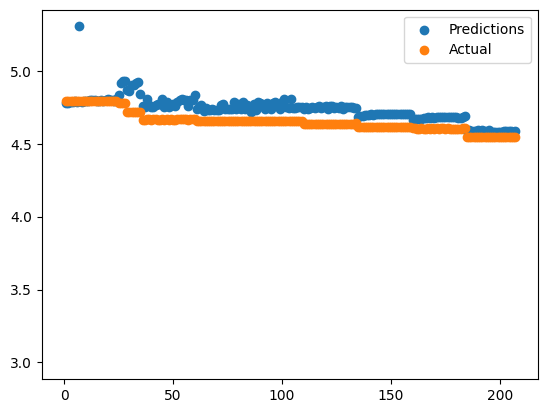

In [229]:
plt.scatter(train_soh_pred['Cycle'], train_soh_pred['Predictions'], label='Predictions')
plt.scatter(train_soh_actual['Cycle'], train_soh_actual['Discharge_Capacity(Ah)'], label='Actual')
plt.legend()
plt.plot(0, 3, label='Predictions', color='white')
